# Moneyball - Exploratory Analysis

## Construct Datasets(Training, Validation Testing) - Baseball Teams and Stats

In [36]:
import pandas as pd
import math

In [37]:
moneyball = pd.read_csv("baseball.csv")

### Overall Dataset

In [38]:
print("Shape:", moneyball.shape)
print("Preview:\n", moneyball.head)

Shape: (1232, 15)
Preview:
 <bound method NDFrame.head of      Team League  Year   RS   RA    W    OBP    SLG     BA  Playoffs  \
0     ARI     NL  2012  734  688   81  0.328  0.418  0.259         0   
1     ATL     NL  2012  700  600   94  0.320  0.389  0.247         1   
2     BAL     AL  2012  712  705   93  0.311  0.417  0.247         1   
3     BOS     AL  2012  734  806   69  0.315  0.415  0.260         0   
4     CHC     NL  2012  613  759   61  0.302  0.378  0.240         0   
...   ...    ...   ...  ...  ...  ...    ...    ...    ...       ...   
1227  PHI     NL  1962  705  759   81  0.330  0.390  0.260         0   
1228  PIT     NL  1962  706  626   93  0.321  0.394  0.268         0   
1229  SFG     NL  1962  878  690  103  0.341  0.441  0.278         1   
1230  STL     NL  1962  774  664   84  0.335  0.394  0.271         0   
1231  WSA     AL  1962  599  716   60  0.308  0.373  0.250         0   

      RankSeason  RankPlayoffs    G   OOBP   OSLG  
0            NaN         

### Training/Validation Subset (1999-2009)

In [39]:
isNot2010s = moneyball["Year"]<2010
moneyballNot2010s = moneyball[isNot2010s]

is1999s = moneyballNot2010s["Year"] >= 1999

#This is our training set. Needs to be divided up later for validation
moneyball_training = moneyballNot2010s[is1999s]

print("Shape: ", moneyball_training.shape)
print("Preview:\n ", moneyball_training.head)

Shape:  (330, 15)
Preview:
  <bound method NDFrame.head of     Team League  Year   RS   RA   W    OBP    SLG     BA  Playoffs  \
90   ARI     NL  2009  720  782  70  0.324  0.418  0.253         0   
91   ATL     NL  2009  735  641  86  0.339  0.405  0.263         0   
92   BAL     AL  2009  741  876  64  0.332  0.415  0.268         0   
93   BOS     AL  2009  872  736  95  0.352  0.454  0.270         1   
94   CHC     NL  2009  707  672  83  0.332  0.407  0.255         0   
..   ...    ...   ...  ...  ...  ..    ...    ...    ...       ...   
415  SFG     NL  1999  872  831  86  0.356  0.434  0.271         0   
416  STL     NL  1999  809  838  75  0.338  0.426  0.262         0   
417  TBD     AL  1999  772  913  69  0.343  0.411  0.274         0   
418  TEX     AL  1999  945  859  95  0.361  0.479  0.293         1   
419  TOR     AL  1999  883  862  84  0.352  0.457  0.280         0   

     RankSeason  RankPlayoffs    G   OOBP   OSLG  
90          NaN           NaN  162  0.330  0.419 

### Testing Subset (2000-2012)

In [40]:
is2010s = moneyball['Year']>=2010
moneyball_test = moneyball[is2010s]

print('Shape:', moneyball_test.shape)
print('Preview:', moneyball_test.head)

Shape: (90, 15)
Preview: <bound method NDFrame.head of    Team League  Year   RS   RA   W    OBP    SLG     BA  Playoffs  RankSeason  \
0   ARI     NL  2012  734  688  81  0.328  0.418  0.259         0         NaN   
1   ATL     NL  2012  700  600  94  0.320  0.389  0.247         1         4.0   
2   BAL     AL  2012  712  705  93  0.311  0.417  0.247         1         5.0   
3   BOS     AL  2012  734  806  69  0.315  0.415  0.260         0         NaN   
4   CHC     NL  2012  613  759  61  0.302  0.378  0.240         0         NaN   
..  ...    ...   ...  ...  ...  ..    ...    ...    ...       ...         ...   
85  STL     NL  2010  736  641  86  0.332  0.402  0.263         0         NaN   
86  TBR     AL  2010  802  649  96  0.333  0.403  0.247         1         2.0   
87  TEX     AL  2010  787  687  90  0.338  0.419  0.276         1         7.0   
88  TOR     AL  2010  755  728  85  0.312  0.454  0.248         0         NaN   
89  WSN     NL  2010  655  742  69  0.318  0.390  0.25

## Construct Graph

In [41]:
graph = {}
weight = {}

### Construct Nodes for Graph

In [42]:
#import baseball_node class
from baseball_node import Baseball_Node

for index, row in moneyball_training.iterrows():
    team, year, league, rs, ra, w, obp, slg, oobp, oslg, playoffs = row['Team'], row['Year'],row['League'],row['RS'],row['RA'],row['W'],row['OBP'],row['SLG'],row['OOBP'],row['OSLG'],row['Playoffs']

    node = Baseball_Node(team, year, league, rs, ra, w, obp, slg, oobp, oslg, playoffs)
    graph[node] = []

### Add Nodes, Edges, and Weights to the Graph

In [43]:
#make a fully connected graph by adding neighbors to adjacency list. Update weight dictionary with the weights of each node edge.
for team1 in graph:
    for team2 in graph:
        if team1 != team2:
            graph[team1].append(team2)
            dist = team1.getEuclideanDistance(team2)
            weight[(team1,team2)] = dist

#### Helper Function for Sorting the Weights

In [44]:
#helper function for sorting
def takeSecond(elem):
    return elem[1]

In [45]:
KNN_Values = [x for x in range(0,51) if x % 2 == 1]
test_teams_count = moneyball_test.shape[0] 

### Run KNN on our Testing Data

In [46]:
def KNN(k_value):
    decision_diffs = []
    for index,row in moneyball_test.iterrows():
        team, year, league, rs, ra, w, obp, slg, oobp, oslg, playoffs = row['Team'], row['Year'],row['League'],row['RS'],row['RA'],row['W'],row['OBP'],row['SLG'],row['OOBP'],row['OSLG'],row['Playoffs']

        test_node = Baseball_Node(team, year, league, rs, ra, w, obp, slg, oobp, oslg, playoffs)
        test_graph = graph
        test_graph[test_node] = []
        test_weights = weight
        for team in test_graph:
            if(team !=test_node):
                test_graph[test_node].append(team)
                test_graph[team].append(test_node)

                dist = team.getEuclideanDistance(test_node)

                test_weights[(team, test_node)] = dist
                test_weights[(test_node, team)] = dist
        
        test_node_neighbors = test_graph[test_node]
        test_node_neighbor_weights = [[neighbor, test_weights[(test_node, neighbor)]] for neighbor in test_node_neighbors]

        test_node_neighbor_weights.sort(key=takeSecond)

        test_node_nighbor_weights = [node for node in test_node_neighbor_weights if node[0].team_id != test_node.team_id]

        KNN_Neighbors = []
        KNN_decision = []

        neighbors = [(team[0], team[1]) for team in test_node_neighbor_weights[:k_value]]
        KNN_Neighbors.append(neighbors)

        decision = 1 if sum([team[0].playoff for team in neighbors]) > 0 else -1
        decision_diff = 1 if decision == team.playoff else 0 
        decision_diffs.append(decision_diff)
    return decision_diffs


In [47]:

success_rates = []

for k in KNN_Values:
    print("Currently Running KNN for K=", k)
    success_rate = round(sum(KNN(k))/test_teams_count, 4)
    success_rates.append(success_rate)

print(success_rates)    


Currently Running KNN for K= 1
Currently Running KNN for K= 3
Currently Running KNN for K= 5
Currently Running KNN for K= 7
Currently Running KNN for K= 9
Currently Running KNN for K= 11
Currently Running KNN for K= 13
Currently Running KNN for K= 15
Currently Running KNN for K= 17
Currently Running KNN for K= 19
Currently Running KNN for K= 21
Currently Running KNN for K= 23
Currently Running KNN for K= 25
Currently Running KNN for K= 27
Currently Running KNN for K= 29
Currently Running KNN for K= 31
Currently Running KNN for K= 33
Currently Running KNN for K= 35
Currently Running KNN for K= 37
Currently Running KNN for K= 39
Currently Running KNN for K= 41
Currently Running KNN for K= 43
Currently Running KNN for K= 45
Currently Running KNN for K= 47
Currently Running KNN for K= 49
[0.7667, 0.8778, 0.8889, 0.8889, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111]


### Graph the Result

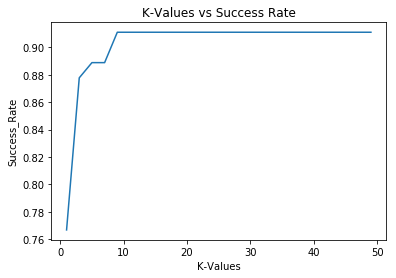

In [48]:
import matplotlib.pyplot as plt
X_Values = KNN_Values
Y_Values = success_rates
plt.xlabel("K-Values")
plt.ylabel("Success_Rate")
plt.title("K-Values vs Success Rate", )
plt.plot(X_Values, Y_Values)
plt.show()